In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from keras.models import Model
from keras.layers import LSTM, Dropout, Dense, Input, GlobalAveragePooling1D
from keras.constraints import MaxNorm

from helpers.attention import AttentionTanh, AttentionRelu
from helpers.dataHelpers import getData, prepareData

In [73]:
data = prepareData()

In [74]:
data.head()

,date_time,energy(kWh/hh),year,quarter,month,day,hour,minute,weekday
0,2012-10-12 00:30:00,0,2012,4,10,12,0,30,1
1,2012-10-12 01:00:00,0,2012,4,10,12,1,0,1
2,2012-10-12 01:30:00,0,2012,4,10,12,1,30,1
3,2012-10-12 02:00:00,0,2012,4,10,12,2,0,1
4,2012-10-12 02:30:00,0,2012,4,10,12,2,30,1


In [75]:
data.tail()

,date_time,energy(kWh/hh),year,quarter,month,day,hour,minute,weekday
24136,2014-02-27 22:00:00,0.416,2014,1,2,27,22,0,1
24137,2014-02-27 22:30:00,1.35,2014,1,2,27,22,30,1
24138,2014-02-27 23:00:00,1.247,2014,1,2,27,23,0,1
24139,2014-02-27 23:30:00,1.2180001,2014,1,2,27,23,30,1
24140,2014-02-28 00:00:00,1.387,2014,1,2,28,0,0,1


In [76]:
print('Liczba wierszy i kolumn:', data.shape)
print('Najstarsza data:', data.date_time.min())
print('Najnowsza data:', data.date_time.max())

Liczba wierszy i kolumn: (24141, 9)
Najstarsza data: 2012-10-12 00:30:00
Najnowsza data: 2014-02-28 00:00:00


In [77]:
data = data.loc[data["energy(kWh/hh)"] != "Null"]

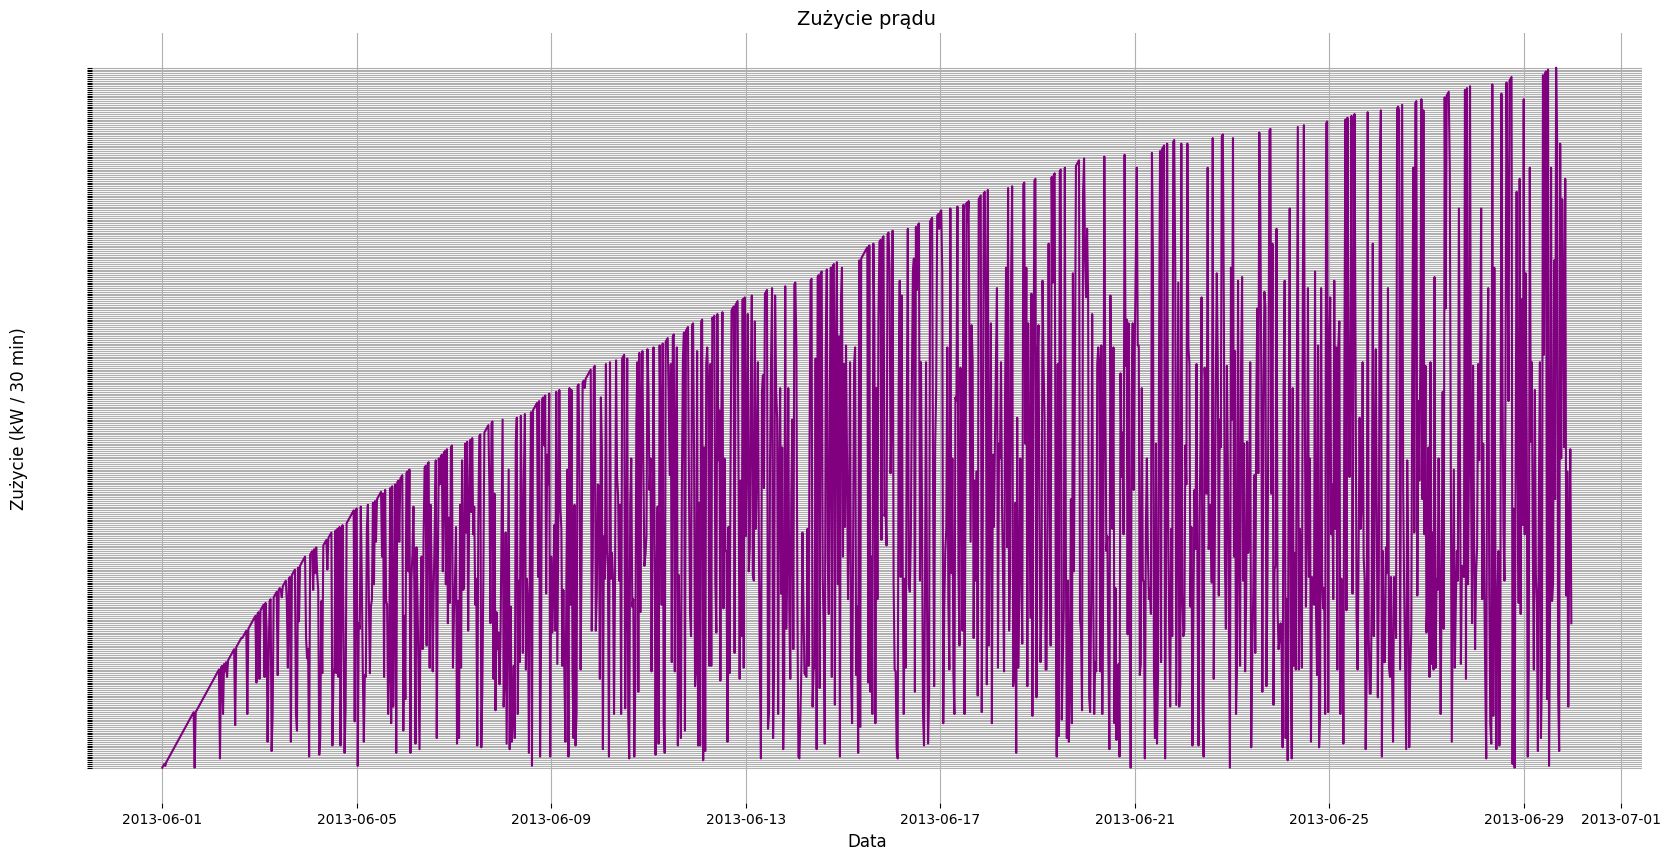

In [78]:
data1 = data[(data.date_time >= '2013-06-01') & (data.date_time < '2013-06-30')]
plt.figure(figsize=(20,10))
plt.plot(data1.date_time, data1["energy(kWh/hh)"], color='purple')
plt.ylabel('Zużycie (kW / 30 min)', fontsize=12)
plt.xlabel('Data', fontsize=12)
plt.title('Zużycie prądu', fontsize=14)
plt.grid(True)
plt.yticks(color='w') #ENGINEER
sns.despine(bottom=True, left=True)
plt.show()

In [79]:
dataset = data["energy(kWh/hh)"].values.astype('float32')
dataset = np.reshape(dataset, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
train_size = int(len(dataset) - 480)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [80]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [81]:
X_train, Y_train = create_dataset(train, 30)
X_test, Y_test = create_dataset(test, 30)
print(X_train.shape)
print(X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape)
print(X_test.shape)

(23629, 30)
(449, 30)
(23629, 1, 30)
(449, 1, 30)


In [82]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_layer = LSTM(units=50, return_sequences=True)(input_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
lstm_layer_2 = LSTM(units=100, return_sequences=True)(dropout_layer)
dropout_layer_2 = Dropout(0.2)(lstm_layer_2)
lstm_layer_3 = LSTM(units=100, return_sequences=True)(dropout_layer_2)
dropout_layer_3 = Dropout(0.2)(lstm_layer_3)
attention_input = GlobalAveragePooling1D()(dropout_layer_3)
attention_layer = AttentionTanh()(attention_input)
lstm_layer_4 = LSTM(units=100, return_sequences=False)(attention_layer)
output_layer = Dense(units = 1, activation='sigmoid', kernel_constraint=MaxNorm(3))(lstm_layer_4)
model = Model(input_layer, output_layer)

model.compile(loss='mae', optimizer='adam')


history = model.fit(X_train, Y_train, epochs=150, batch_size=96, validation_data=(X_test, Y_test), verbose=2, shuffle=False)

Epoch 1/150


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "lstm_25" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 1, 30), dtype=float32)
  • training=True
  • mask=None

In [ ]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1, 30)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 1, 50)          │        16,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 1, 100)         │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 1, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_tanh_1                │ (None, 100, 32)        │         9,600 │
│ (AttentionTanh)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100, 1)         │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499,901 (1.91 MB)

 Trainable params: 166,633 (650.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 333,268 (1.27 MB)

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Średni błąd bezwzględny na zbiorze testowym:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Pierwiastek z błędu średniokwadratowego na zbiorze testowym: ',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Średni błąd bezwzględny na zbiorze treningowym:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Pierwiastek z błędu średniokwadratowego na zbiorze testowym:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

739/739 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step
Średni błąd bezwzględny na zbiorze testowym: 0.08226984101663734
Pierwiastek z błędu średniokwadratowego na zbiorze testowym:  0.16898589468359332
Średni błąd bezwzględny na zbiorze treningowym: 0.08874654292010584
Pierwiastek z błędu średniokwadratowego na zbiorze testowym: 0.16058807684612073


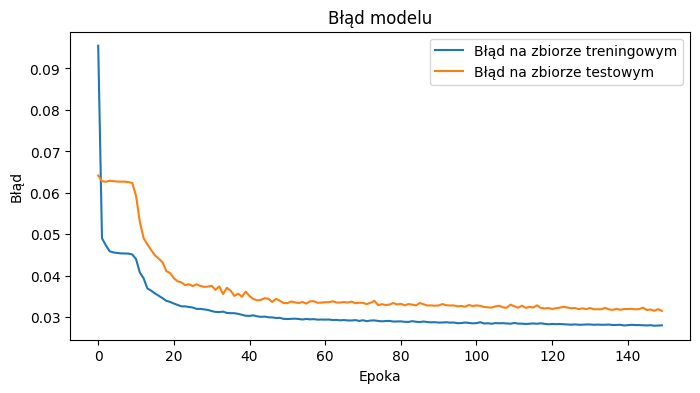

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Błąd na zbiorze treningowym')
plt.plot(history.history['val_loss'], label='Błąd na zbiorze testowym')
plt.title('Błąd modelu')
plt.ylabel('Błąd')
plt.xlabel('Epoka')
plt.legend(loc='upper right')
plt.show()

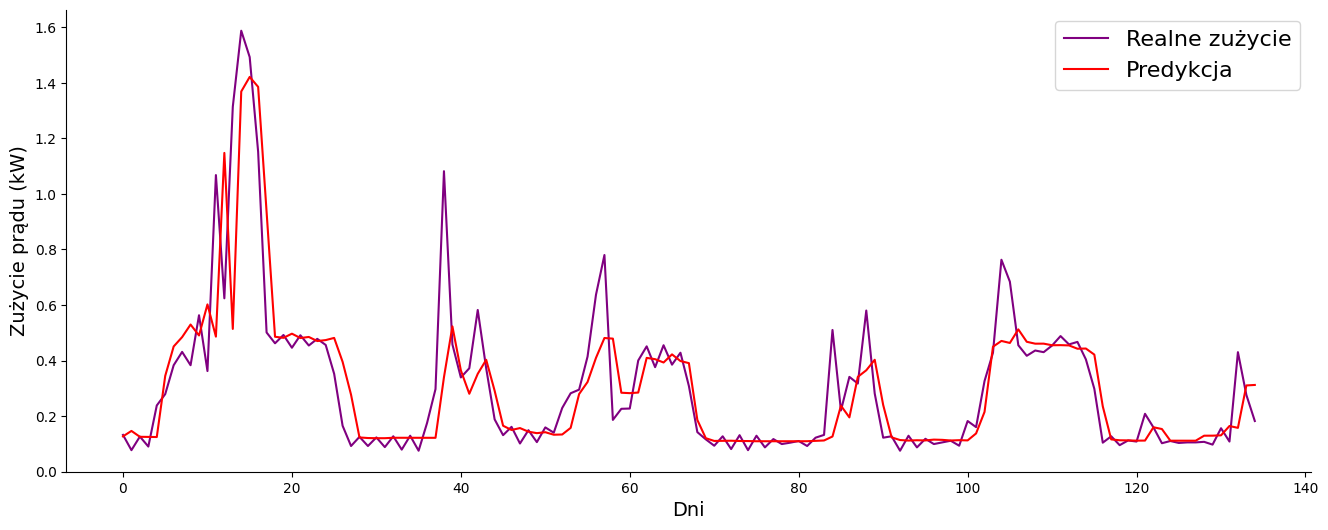

In [ ]:
aa=[x for x in range(135)]
                    
plt.figure(figsize=(15,6))
plt.plot(aa, Y_test[0][:135], label="Realne zużycie", color='purple')
plt.plot(aa, test_predict[:,0][:135], label="Predykcja", color='red')
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Zużycie prądu (kW)', size=14)
plt.xlabel('Dni', size=14)
plt.legend(fontsize=16)
plt.show()

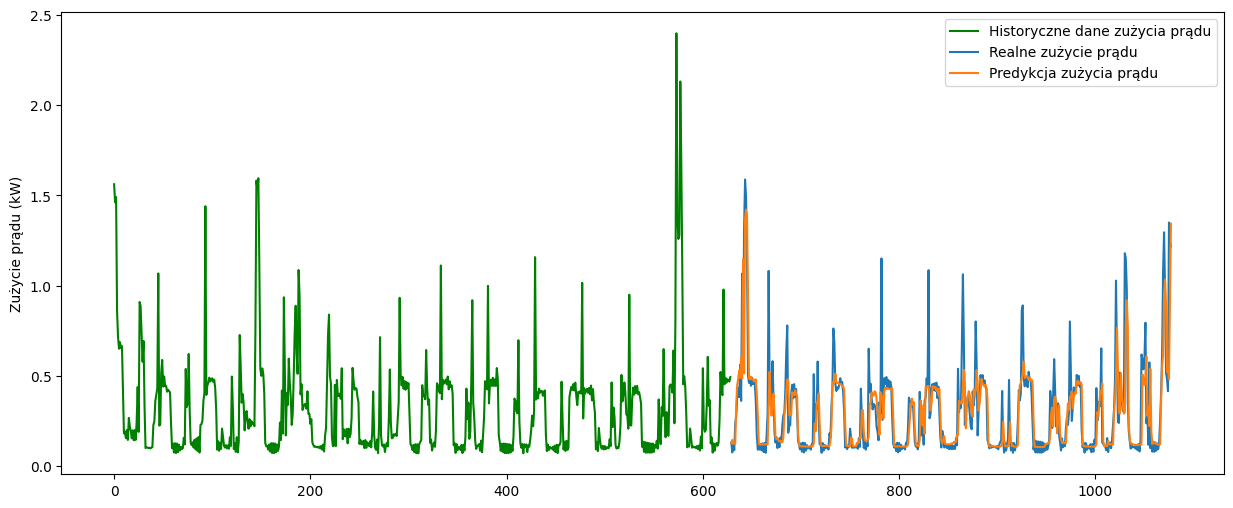

In [ ]:
aa=[x for x in range(30)]
plt.figure(figsize=(15,6))
plt.plot(np.arange(0, len(Y_train[0][23000:23630])), Y_train[0][23000:23630], 'g', label="Historyczne dane zużycia prądu")
plt.plot(np.arange(len(Y_train[0][23000:23630]), len(Y_train[0][23000:23630]) + len(Y_test[0])), Y_test[0], label="Realne zużycie prądu")
plt.plot(np.arange(len(Y_train[0][23000:23630]), len(Y_train[0][23000:23630]) + len(Y_test[0])), test_predict[:,0], label="Predykcja zużycia prądu")
plt.ylabel('Zużycie prądu (kW)')
plt.legend()
plt.show()